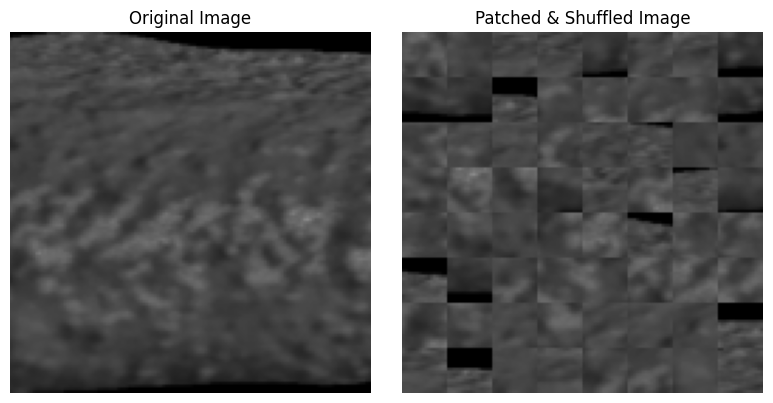

Label for this image: 0


In [18]:
import os
import random
import torch
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from dataset import TextureWindowDataset
from patch import PatchShuffleTransform


# Paths
data_dir = "data/texture_windows"
csv_path = "data/texture_windows-labels.csv"

# Basic resize transform
base_resize_transform = transforms.Resize((128, 128))

# Initialize dataset
dataset = TextureWindowDataset(csv_path=csv_path, images_dir=data_dir, transform=base_resize_transform)

# Pick a random image from the dataset
idx = random.randint(0, len(dataset)-1)
original_img, label = dataset[idx]

# Apply patch and shuffle
patch_transform = PatchShuffleTransform(patch_size=16)
patched_img = patch_transform(original_img)

# Display original and patched images side-by-side
fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].imshow(original_img)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(patched_img)
axes[1].set_title("Patched & Shuffled Image")
axes[1].axis("off")

plt.tight_layout()
plt.show()

print(f"Label for this image: {label}")


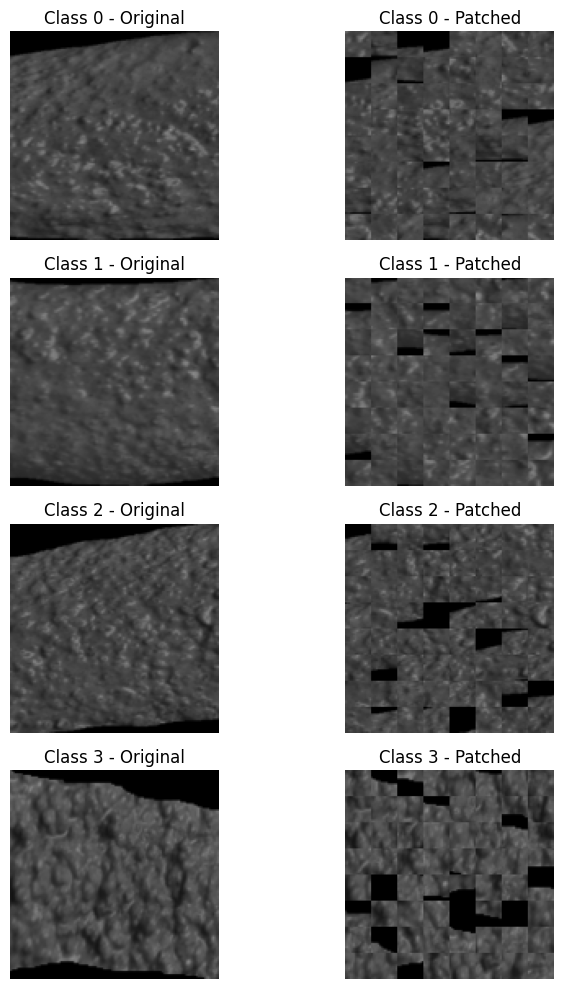

In [11]:
class PatchShuffleTransform:
    def __init__(self, patch_size=16):
        self.patch_size = patch_size
        
    def __call__(self, img):
        img_tensor = transforms.functional.to_tensor(img)  # C,H,W
        C, H, W = img_tensor.shape
        assert H % self.patch_size == 0 and W % self.patch_size == 0, "H and W must be divisible by patch_size"
        
        num_patches_h = H // self.patch_size
        num_patches_w = W // self.patch_size
        
        # Extract patches
        patches = img_tensor.unfold(1, self.patch_size, self.patch_size).unfold(2, self.patch_size, self.patch_size)
        # patches shape: C, num_patches_h, num_patches_w, patch_size, patch_size
        patches = patches.permute(1, 2, 0, 3, 4)  # (num_patches_h, num_patches_w, C, patch_size, patch_size)
        
        patches_list = patches.reshape(num_patches_h * num_patches_w, C, self.patch_size, self.patch_size)
        
        # Shuffle patches
        patches_list = list(patches_list)
        random.shuffle(patches_list)
        patches_shuffled = torch.stack(patches_list, dim=0)
        
        # Reshape back
        patches_shuffled = patches_shuffled.reshape(num_patches_h, num_patches_w, C, self.patch_size, self.patch_size)
        patches_shuffled = patches_shuffled.permute(2, 0, 3, 1, 4).reshape(C, H, W)
        
        return transforms.functional.to_pil_image(patches_shuffled)

# Paths
data_dir = "data/texture_windows"
csv_path = "data/texture_windows-labels.csv"

# Basic resize transform
base_resize_transform = transforms.Resize((128, 128))

# Initialize dataset
dataset = TextureWindowDataset(csv_path=csv_path, images_dir=data_dir, transform=base_resize_transform)

# We want one image from each class: 0,1,2,3
classes_needed = [0,1,2,3]
class_examples = {}

# Find an example for each class
for i in range(len(dataset)):
    img, label = dataset[i]
    if label in classes_needed and label not in class_examples:
        class_examples[label] = (img, label)
    if len(class_examples) == len(classes_needed):
        break

# Patch transform
patch_transform = PatchShuffleTransform(patch_size=16)

# We'll create a figure with 4 rows and 2 columns:
# Each row: original (left) and patched (right)
fig, axes = plt.subplots(len(classes_needed), 2, figsize=(8, 10))

for idx, cls in enumerate(classes_needed):
    original_img, lbl = class_examples[cls]
    patched_img = patch_transform(original_img)
    
    axes[idx, 0].imshow(original_img)
    axes[idx, 0].set_title(f"Class {cls} - Original")
    axes[idx, 0].axis("off")
    
    axes[idx, 1].imshow(patched_img)
    axes[idx, 1].set_title(f"Class {cls} - Patched")
    axes[idx, 1].axis("off")

plt.tight_layout()
plt.show()
